In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, Dense, Dropout, Add, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2021-11-15 15:31:19.548947: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


2.5.0


In [2]:
path = 'Dataset3/'
x1_train = pd.read_csv(path+'data_trainmid_x1.csv')
x2_train = pd.read_csv(path+'data_trainmid_x2.csv')
f1_train = pd.read_csv(path+'data_trainmid_f1.csv')
f1_test = pd.read_csv(path+'data_testmid_f1.csv')
x1_test = pd.read_csv(path+'data_testmid_x1.csv')
x2_test = pd.read_csv(path+'data_testmid_x2.csv')
print(len(x1_train),len(x1_test),len(f1_train),len(f1_test))
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1),columns = ['p1','p2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1),columns = ['p1','p2'])
X_train.head()

112459 62211 112459 62211


,p1,p2
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [3]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [4]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    importances = rf.feature_importances_
    plt.figure(figsize=(20,5))
    x_plot = ['x1(n{})'.format(-i) for i in range(0,m*t,t)] + ['x2(n{})'.format(-i) for i in range(0,m*t,t)]
    plt.plot(x_plot,importances, label = 'Importance Plot')
    plt.legend()
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.title('Importance plot for random forest')
    plt.show()
    
    # RBF MODEL
    rbf_results = []
    inp = Input(shape=(m*2))
    for i in range(10):
        x = RBFLayer(10, 0.5)(inp)
        rbf_results.append(x)
    y = Add()(rbf_results)
    y = Dense(1)(y)
    model = Model(inputs = inp, outputs = y)
    model.compile(optimizer = 'adam', loss = 'mse')
    
    t1 = datetime.now()
    model.fit(x_train, y_train, epochs = 16)
    t2 = datetime.now()

    print('Time taken by RBF Model: ',t2-t1)
    y1_pred = model.predict(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    
    # SVR MODEL
    t1 = datetime.now()
    clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('Time taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    # Deep Learning Model
    inp = Input((m*2))
    x = Dense(9,activation = 'relu')(inp)
    x = Dense(12,activation = 'relu')(x)
    x = Dense(1)(x)

    model = Model(inputs = inp, outputs = x)
    model.compile(optimizer = 'adam', loss = 'mse')
    t3 = datetime.now()
    his = model.fit(x_train,y_train, epochs=15)
    t4 = datetime.now()
    print('Time taken by Deep Learning Model',t4-t3)
    y1_pred = model.predict(x_test)
    y3 = y1_pred
    print('Root mean squared error:',sqrt(mean_squared_error(y_test,y1_pred)))
    error2 = []
    for i in range(len(y_test)):
        error2.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error2))
    print('Maximum Error =',max(error2))
    error3 = sorted(error2)
    print('Median Value of Error =',error3[len(error)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y3[:6000], label = 'Deep Learning')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error2, label = 'Error of Deep Learning')
    plt.plot(list(range(len(y1_pred))),error7, label = 'Error of SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error2[:6000], label = 'Deep Learning model')
    plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

Time taken by Random Forest 0:01:45.626063
Root Mean Squared error of Random Forest 0.059331585612262275
Minimum Error = 9.999999996956888e-07
Maximum Error = 0.8932230000000005
Median Value of Error = 0.018948


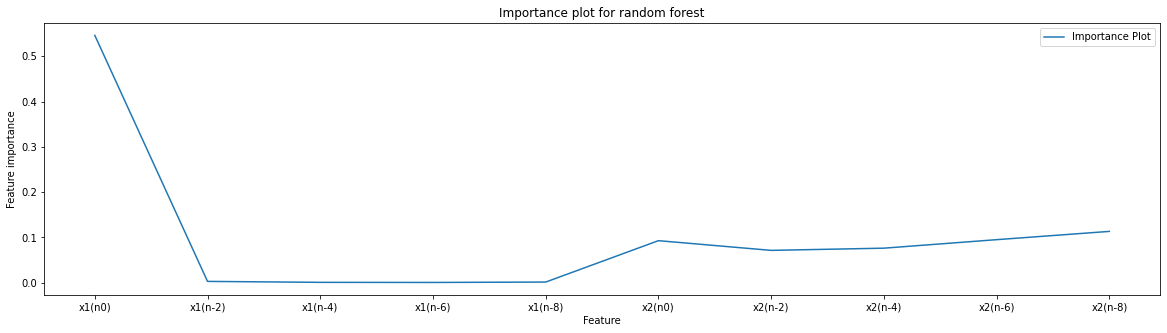

2021-11-15 15:35:06.048459: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-15 15:35:06.201143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-15 15:35:06.203407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-15 15:35:06.205611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:07:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2

Epoch 1/16
3515/3515 [==============================] - 7s 2ms/step - loss: 1.1741
Epoch 2/16
3515/3515 [==============================] - 6s 2ms/step - loss: 0.9265
Epoch 3/16
3515/3515 [==============================] - 6s 2ms/step - loss: 0.8695
Epoch 4/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8286
Epoch 5/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8001
Epoch 6/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.7788
Epoch 7/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.7645
Epoch 8/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.7522
Epoch 9/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.7407
Epoch 10/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.7303
Epoch 11/16
3515/3515 [==============================] - 6s 2ms/step - loss: 0.7206
Epoch 12/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.7094
E

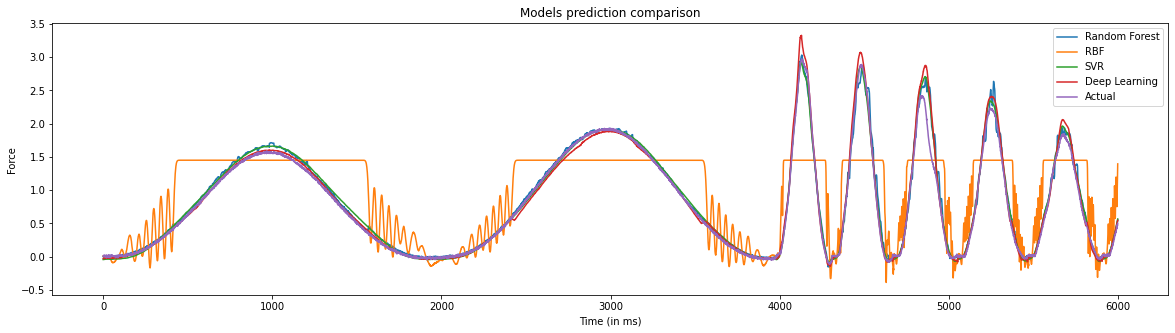

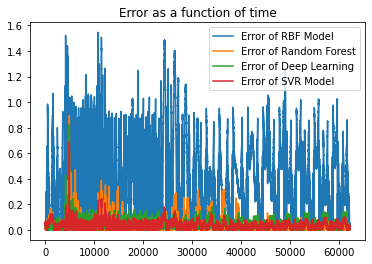

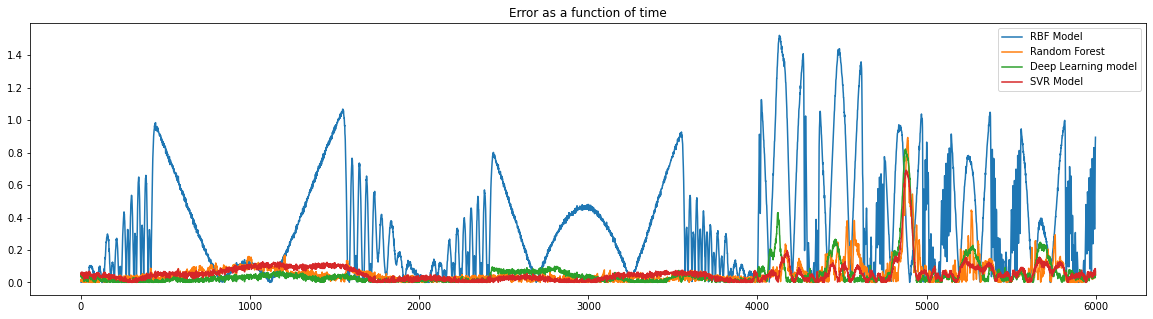

In [5]:
get_results(t=2, m=5)

Time taken by Random Forest 0:00:46.599791
Root Mean Squared error of Random Forest 0.0631446927998642
Minimum Error = 0.0
Maximum Error = 0.9359510000000013
Median Value of Error = 0.021059999999999968


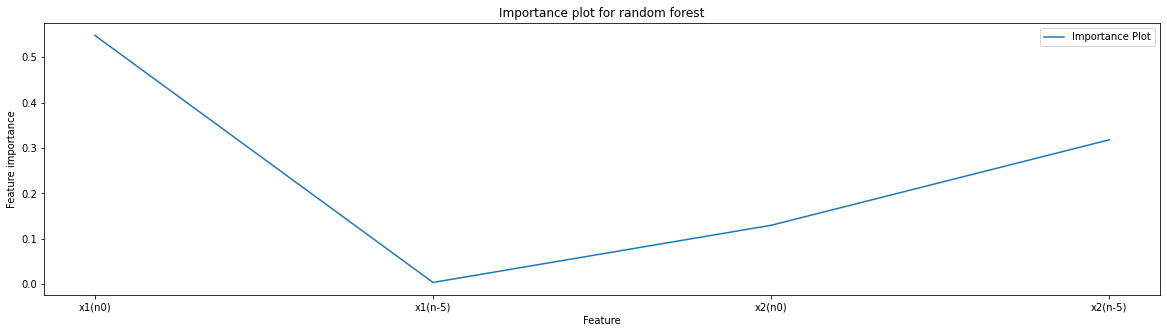

Epoch 1/16
3515/3515 [==============================] - 6s 1ms/step - loss: 1.0031
Epoch 2/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.8397
Epoch 3/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.7652
Epoch 4/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.7250
Epoch 5/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.6792
Epoch 6/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.6272
Epoch 7/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.5897
Epoch 8/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.5797
Epoch 9/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.5744
Epoch 10/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.5680
Epoch 11/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.5620
Epoch 12/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.5564
E

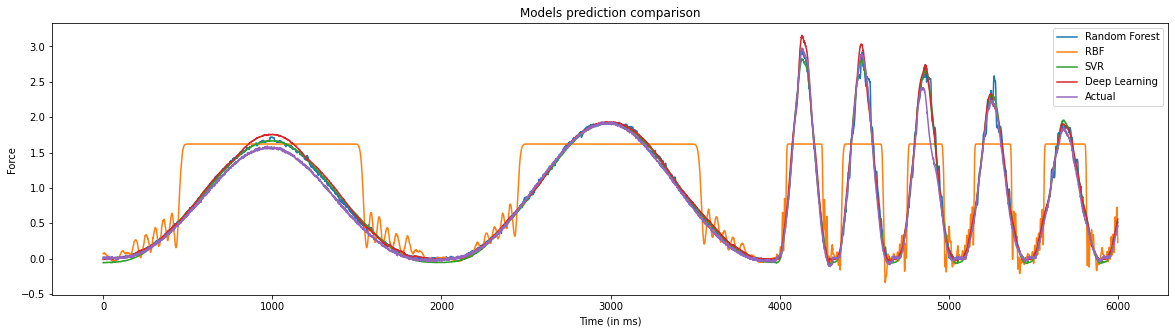

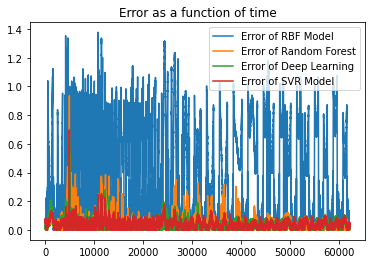

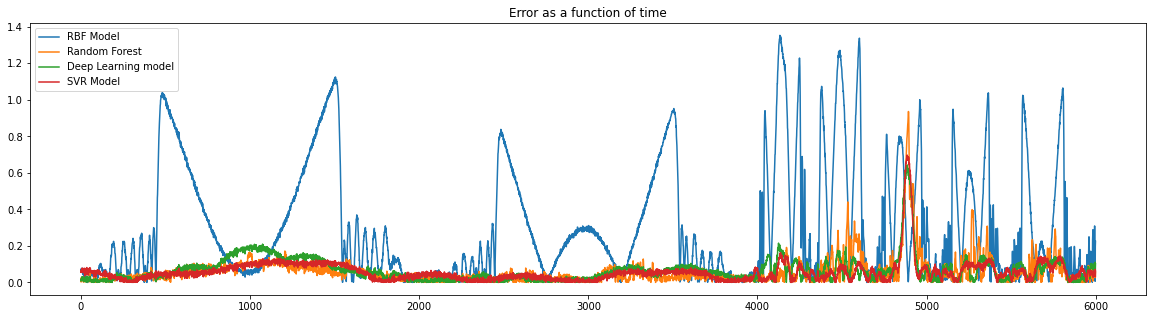

In [6]:
get_results(t=5, m=2)

Time taken by Random Forest 0:03:20.309340
Root Mean Squared error of Random Forest 0.058135634781467126
Minimum Error = 1.999999999946489e-06
Maximum Error = 0.8901849999999996
Median Value of Error = 0.018167999999999962


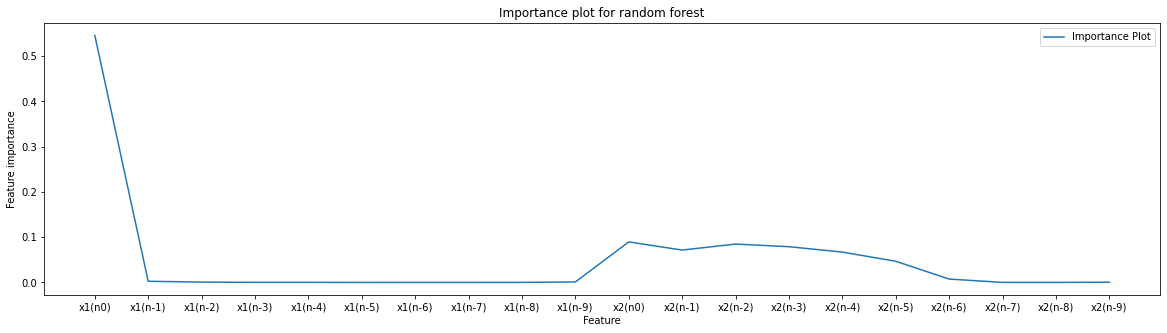

Epoch 1/16
3515/3515 [==============================] - 7s 2ms/step - loss: 1.0936
Epoch 2/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.9315
Epoch 3/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8930
Epoch 4/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8695
Epoch 5/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.8564
Epoch 6/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8455
Epoch 7/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8351
Epoch 8/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8262
Epoch 9/16
3515/3515 [==============================] - 6s 2ms/step - loss: 0.8192
Epoch 10/16
3515/3515 [==============================] - 5s 1ms/step - loss: 0.8132
Epoch 11/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8081
Epoch 12/16
3515/3515 [==============================] - 5s 2ms/step - loss: 0.8040
E

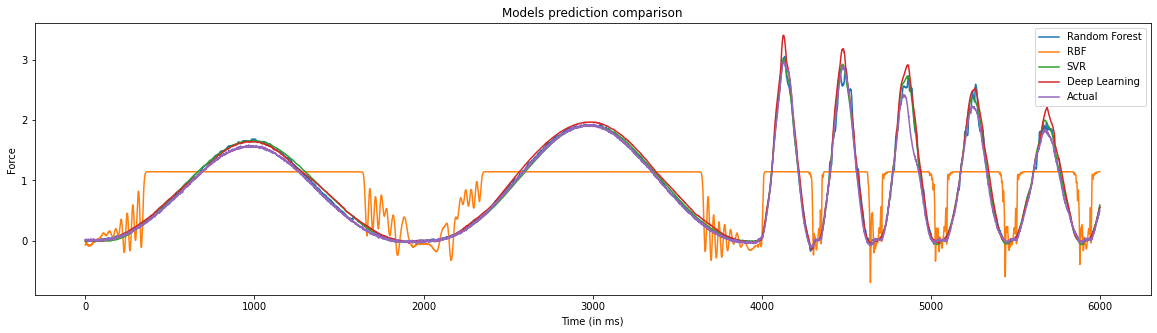

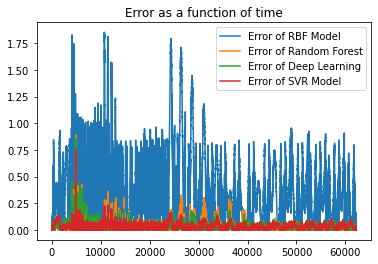

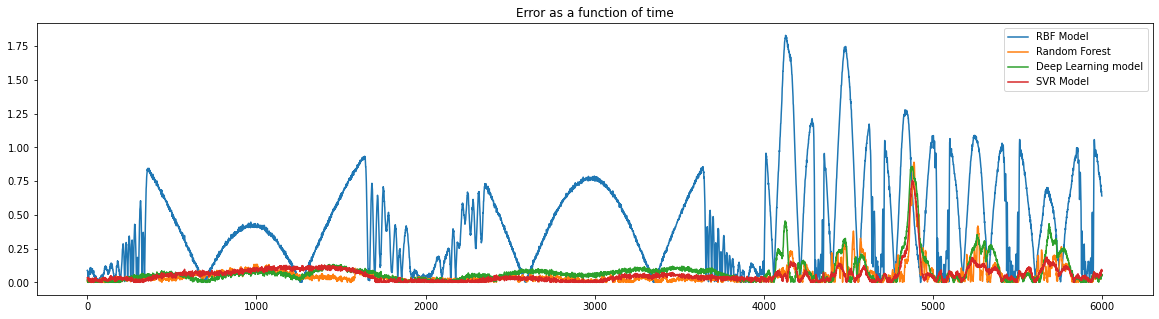

In [7]:
get_results(t=1, m=10)